<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Scores/metrics-and-comparison-with-TF-version" data-toc-modified-id="Scores/metrics-and-comparison-with-TF-version-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scores/metrics and comparison with TF version</a></span></li><li><span><a href="#Sensitivity-to-network-architecture" data-toc-modified-id="Sensitivity-to-network-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sensitivity to network architecture</a></span><ul class="toc-item"><li><span><a href="#My-suggestions-for-the-talk" data-toc-modified-id="My-suggestions-for-the-talk-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>My suggestions for the talk</a></span></li><li><span><a href="#My-CNN-architectures" data-toc-modified-id="My-CNN-architectures-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>My CNN architectures</a></span></li></ul></li><li><span><a href="#Sensitivity-to-amount-of-training-data" data-toc-modified-id="Sensitivity-to-amount-of-training-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sensitivity to amount of training data</a></span></li><li><span><a href="#More-detailed-analysis-of-network-predictions" data-toc-modified-id="More-detailed-analysis-of-network-predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>More detailed analysis of network predictions</a></span><ul class="toc-item"><li><span><a href="#Plot-random-samples" data-toc-modified-id="Plot-random-samples-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plot random samples</a></span></li><li><span><a href="#Lat-lev-slices-of-SPDT/SPDQ-and-QRL/QRS" data-toc-modified-id="Lat-lev-slices-of-SPDT/SPDQ-and-QRL/QRS-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Lat-lev slices of SPDT/SPDQ and QRL/QRS</a></span></li></ul></li></ul></div>

# Analysis and figures for Mike's AGU talk

To do:
- sensitivity to training length
- sensitivity to network architecture

Then pick one model (the "best") and:
- show some random samples
- show some slices and maps (could be made into animations)
- some further in depth analysis

**Basic setup**

All of the models below are trained with the lowest 21 levels of CAM and use the following inputs/features to predict the following outputs/targets:

*Features*: [TAP, QAP, dTdt_adiabatic, dQdt_adiabatic, SHFLX, LHFLX, SOLIN], where the first 4 variables are are 3D fields (so 21 level) and the last 3 are 2D fields with 1 level. For the network they were stacked to create one vector with length 87 and then normalized (subtract mean, divide by std)

*Targets*: [SPDT, SPDQ, QRL, QRS, PRECT, FLUT]. The first 4 are 3D, the last 2 are 2D. Again the variables were stacked to create a vector with length 86. Here we rescaled the variables to be roughly the same order of magnitude (however, this might not be so cleverly done, see analysis below). The rescaling factors for the variables are [C_P, L_V, C_P, C_P, 1e3\*24\*3600 \* 1e-3, 1e5].

*Train/Validation split*: The data for training and testing were split by time. We have 2+ years of Aquaplanet simulations. For validation we are always using the entirety of year 2. For training, we are using subsections of year 1 (to test training length sensitivity). For training the samples (which are flattened from time, lat, lon) are randomly shuffled. This actually brings a large improvement in score (thanks to Gregor Orban for the tip!). 1 year of data equals around 143 million samples.

In [226]:
# Imports
from importlib import reload
import utils; reload(utils); from utils import *
import tensorflow as tf
import keras
import netCDF4 as nc
import h5py
sns.set_style('dark')
sns.set_context('talk')
%matplotlib inline
import pandas as pd
from IPython.display import SVG, HTML
from keras.utils.vis_utils import model_to_dot

# Setup
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [2]:
data_dir = '/local/S.Rasp/cbrain_data/'

In [31]:
feature_names = ['TAP', 'QAP', 'dTdt_adiabatic', 'dQdt_adiabatic', 'SHFLX', 'LHFLX', 'SOLIN']
target_names = ['SPDT', 'SPDQ', 'QRL', 'QRS', 'PRECT', 'FLUT']

## Scores/metrics and comparison with TF version

Let's start out by looking a little at which score to use to compare the different architectures and training lengths. This issue actually causes me quite a bit of grievance. Here it goes:

- The way the scores are computed in Keras vs. TF are slightly different (e.g. the order in which the scores are averaged in z and sample direction). And some metrics (R2 and I think also the log loss as it is in TF) depend on the batch size which is different for mine and Pierre's runs. This means right now the scores are unfortunately not comparable :( 
- Additionally, Pierre is predicting SPDT, SPDQ separately from QRS, QRL. I think it will be interesting to try out how the fits respond to that in the future. But again, this makes an immediate comparison impossible
- Despite our rescaling, the magnitudes of the target variables are not really similar (see plot below). The fits are still ok as you can see below. This is definitely something to go back to (output normalization?). But this also means that many of the average scores weigh some variables more than others.

This last issue makes it hard to compare different experiments with one score, but for the sensitivities below, I want to do it anyway. What gives me confidence is that the order of the experiments is similar for different scores. The score I will use is the mean explained variance. This I will define as 
$$ \frac{1}{N_z}\sum_z 1 - (\mathrm{squared\,error}(z) / \mathrm{target\,variance}(z))$$

Later on we will look at the individual variables.

In [41]:
# Load means and stds
norm = nc.Dataset(data_dir + 'year1_norm.nc')

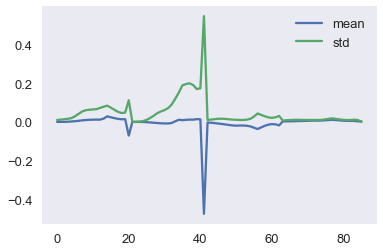

In [6]:
plt.plot(norm.variables['target_means'], label='mean')
plt.plot(norm.variables['target_stds'], label='std')
plt.legend()
plt.show()

The variables in order are SPDT, SPDQ, QRL, QRS, PRECT, FLUT. Lower levels are further to the right. This basically means, that the lower levels of SPDQ are much larger in magnitude than some of the others. 

## Sensitivity to network architecture

Here I will just compare a few model architectures. All of them were trained with a training set containing day 1-3 from each of the 12 months in year 1 of the data.

In [7]:
model_names = [
    '005_1month_distr_shuffle',   # Base model: 1024, 1024, 512, 512 --> 1,971,286 parameters
    '011_1month_log_loss',        # Same model, but with log_loss minimization
    '021_1month_miniscule',       # Dense, one hidden layer 256 nodes --> 44,630 parameters
    '016_1month_tiny',            # One hidden layer 512 nodes
    '017_1month_small',           # 512-512
    '018_1month_medium',          # 1024, 1024
    '022_1month_narrow_deep',     # 128, 128, 128, 128
    '023_1month_broad_shallow',   # 2048
    '019_1month_conv',            # Convolution with 6x32 + 1x6 + flatten + dense linear
    '020_1month_local_conv',      # Local convolution with 2x20 + 1x6 + flatten + dense linear
]

In [8]:
# # Compute scores for all models, takes a long time. Results are saved!
# score_list = []
# for model in model_names:
#     score_list.append(run_diagnostics(
#     './models/' + model + '.h5', 
#     data_dir,
#     'valid_year1', 
#     data_dir + 'year1_norm.nc',
#     convo=True if 'conv' in model else False,
# ))

In [9]:
# df = pd.DataFrame({
#     'Experiment': [n[4:] for n in model_names], 
#     'Explained variance': [np.mean(1-v[0]) for v in score_list],
# })
# df.to_csv('./network_sensitivity.csv')

In [10]:
# # Go through all models and save number of parameters
# param_list = []
# for model in model_names:
#     m = keras.models.load_model('./models/' + model + '.h5')
#     param_list.append(m.count_params())

In [11]:
# df['Parameters'] = param_list

In [12]:
# df.to_csv('./network_sensitivity.csv')

In [13]:
df = pd.read_csv('./network_sensitivity.csv')

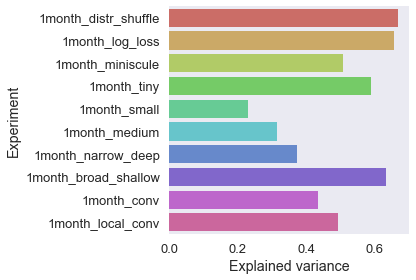

In [14]:
sns.barplot(y='Experiment', x='Explained variance', data=df, palette='hls')
plt.tight_layout()

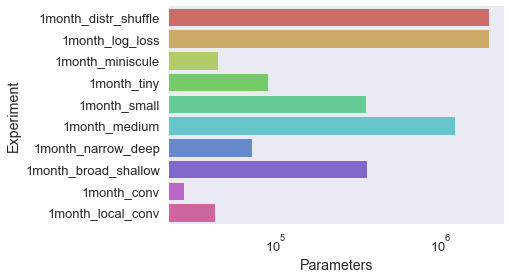

In [22]:
sns.barplot(y='Experiment', x='Parameters', data=df, palette='hls')
plt.xscale('log')

The best network is the default 1024-1024-512-512 dense model. After that the results are confusing because the fits do not scale with the number of parameters. For example, a single layer network with 256 nodes (miniscule) performs much better than a two layer network with 512-512 nodes. In general, it seems that shallow wide networks are better than narrow deep.

### My suggestions for the talk

For the AGU talk maybe a figure plotting the number of parameters against the score would be good. See a first draft below. If you think this is the best way of displaying this sensitivity, I would color-code and annotate the figure highlighting the different architectures. As key points for this sensitivity my suggestions would be:

- Very complex network (approx. 2 million parameters) provides best results, but more parameters do not automatically produce a better fit
- Network architecture matters! Wide, shallow networks seems to be better than narrow, deep networks.
- Convolutions could provide a way of reducing the number of parameters *(my results do not show this, but I think we need to test this further)*
- Similar results for mean absolute error and log RMSE minimization.

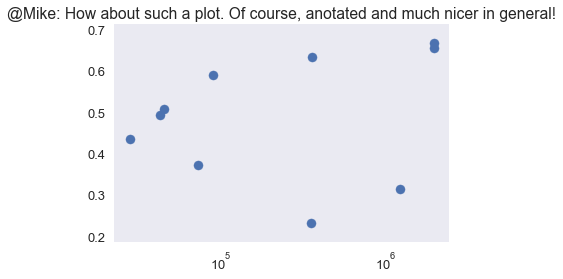

In [26]:
# plot for the talk?
plt.scatter(df['Parameters'], df['Explained variance'])
plt.xscale('log')
plt.title('@Mike: How about such a plot. Of course, anotated and much nicer in general!');

### My CNN architectures

A note about my convolutional networks. The architecture is slightly different than Pierre's because I am predicting SPD\*, QR\*, PRECT and FLUT at the same time, see graphs and explanation below.

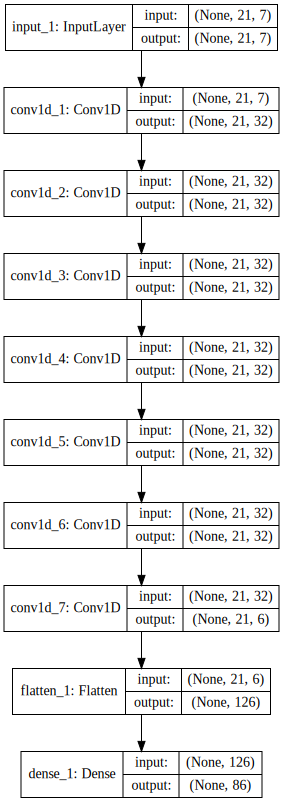

In [17]:
model = keras.models.load_model('./models/019_1month_conv.h5')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

I think the architecture mirrors the TF implementation until the last Conv1D layer. At this point in TF there is a final convolution layer with two channels which are then taken directly as the output (e.g. SPDT and SPDQ). In my case I am using a convolution layer with 6 channels, followed by a flattening operation and a final dense layer. This final dense layer makes up around half of the parameters of the model. Next up the locally connected model.

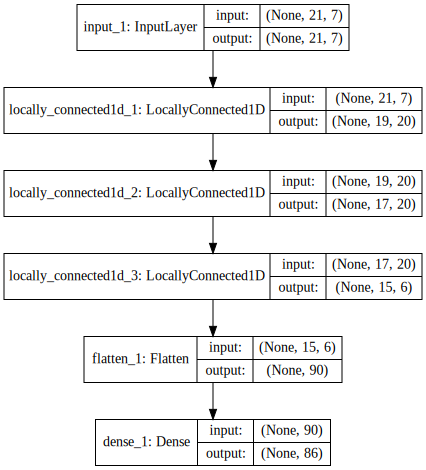

In [20]:
model = keras.models.load_model('./models/020_1month_local_conv.h5')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In my quick test a model with one dense layer provides better results with a similar number of parameters. Note also that convolution operations take more time than a the matrix multiplication in a dense layer. But of course, my architecture is different from the TF implementation, so that is something to explore again later. 

## Sensitivity to amount of training data

For this we are comparing the following training sets:
- 1 month continuous
- days 1-3 from each month (roughly comparable amount of data)
- 3 month continuous
- 1 year

In [27]:
model_names = [
    '024_1month_cont_shuffle',
    '005_1month_distr_shuffle',
    '025_3month_cont_shuffle',
    '002_1year_shuffle'
]

In [ ]:
# # Compute scores for all models... running in iPython notebook
# score_list = []
# for model in model_names:
#     score_list.append(run_diagnostics(
#     './models/' + model + '.h5', 
#     data_dir,
#     'valid_year1', 
#     data_dir + 'year1_norm.nc',
#     convo=True if 'conv' in model else False,
# ))

In [ ]:
# df = pd.DataFrame({
#     'Experiment': [n[4:] for n in model_names], 
#     'Explained variance': [np.mean(1-v[0]) for v in score_list],
# })
# df.to_csv('./training_sensitivity.csv')

In [28]:
df2 = pd.read_csv('./training_sensitivity.csv')

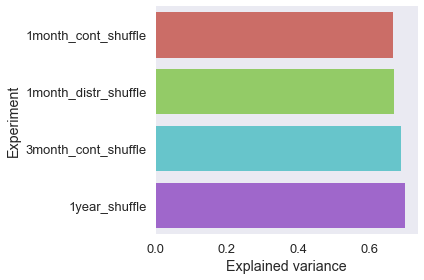

In [29]:
sns.barplot(y='Experiment', x='Explained variance', data=df2, palette='hls')
plt.tight_layout()

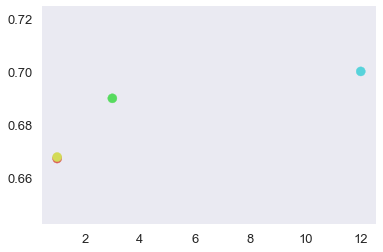

In [30]:
plt.scatter(df2['Months'], df2['Explained variance'], c=colors)

For the talk I would suggest a plot like tho one above showing the amount of training data against the score. I have a 2 and a 6 months experiment running. This should help us get a better line. As key points, I would suggest:

- More training data gives a better validation fit but the increase levels off after 3 months
- In out Aquaplanet data, it makes little difference whether the data is continuous from one month or distributed across seasons. Not sure how this would generalize to real globe with continents.
- This could motivate short (approx. 3 months), expensive runs. 

## More detailed analysis of network predictions

For all further analysis we will use the "best" model which is the 1024-1024-512-512 model with the MAE minimization. Everything below is done using the validation data that the network has not seen during training!

### Plot random samples

These are some random samples showing the input and output profiles. Not sure if you want that, but if you have time it could illustrate the task of the network!

In [33]:
# Load some data
target_file = h5py.File(data_dir + 'valid_year1_targets.nc', 'r')
feature_file = h5py.File(data_dir + 'valid_year1_features.nc', 'r')

In [34]:
# Dimensions to be able to reshape array
n_lon = 128; n_lat = 64; n_geo = n_lat * n_lon

In [36]:
# Load the first 3 days
sample_targets = target_file['targets'][:3*n_geo, :]
sample_features = feature_file['features'][:3*n_geo, :]

In [71]:
# Load the best model
model = keras.models.load_model('./models/002_1year_shuffle.h5')

In [39]:
# Get predictions
sample_preds = model.predict(sample_features)

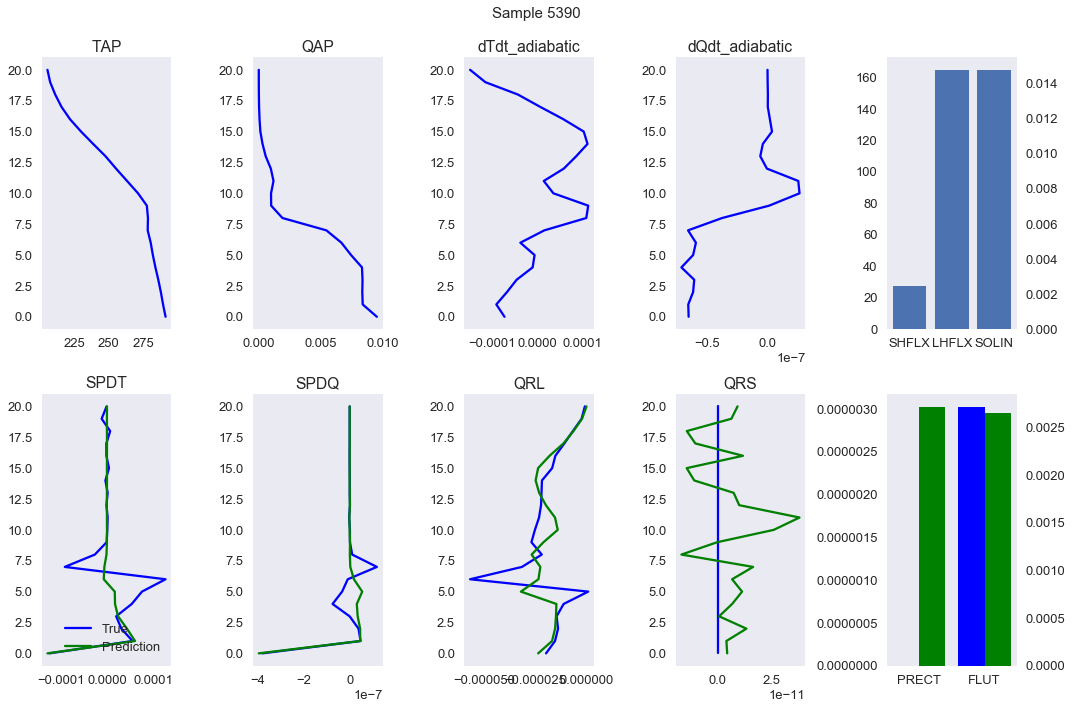

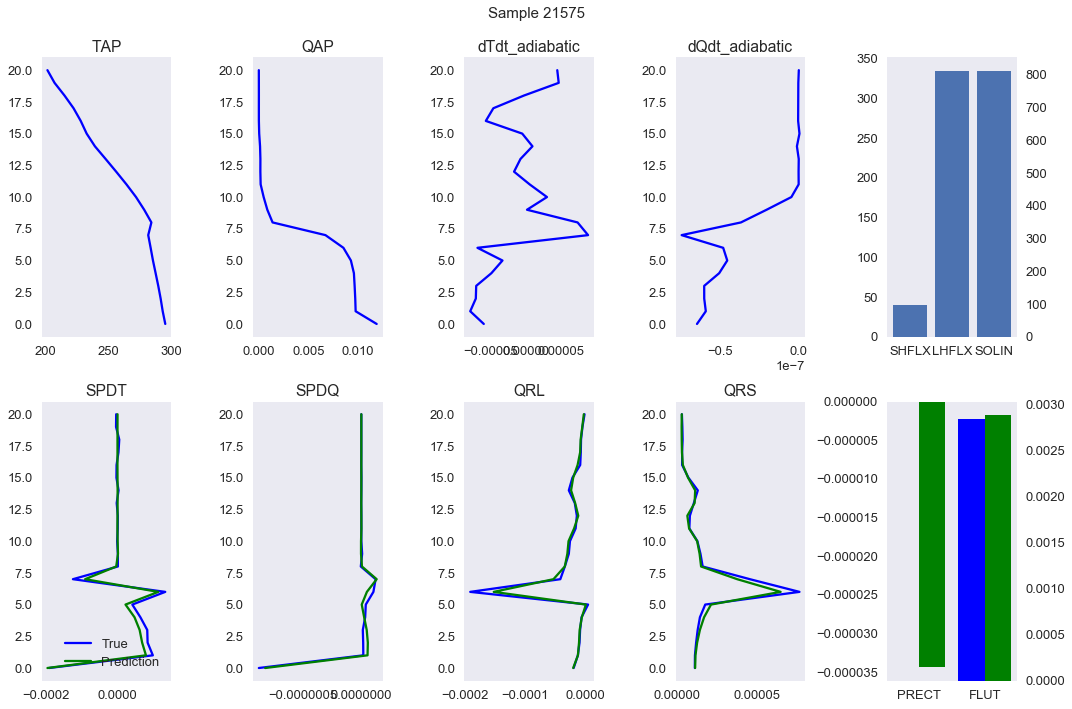

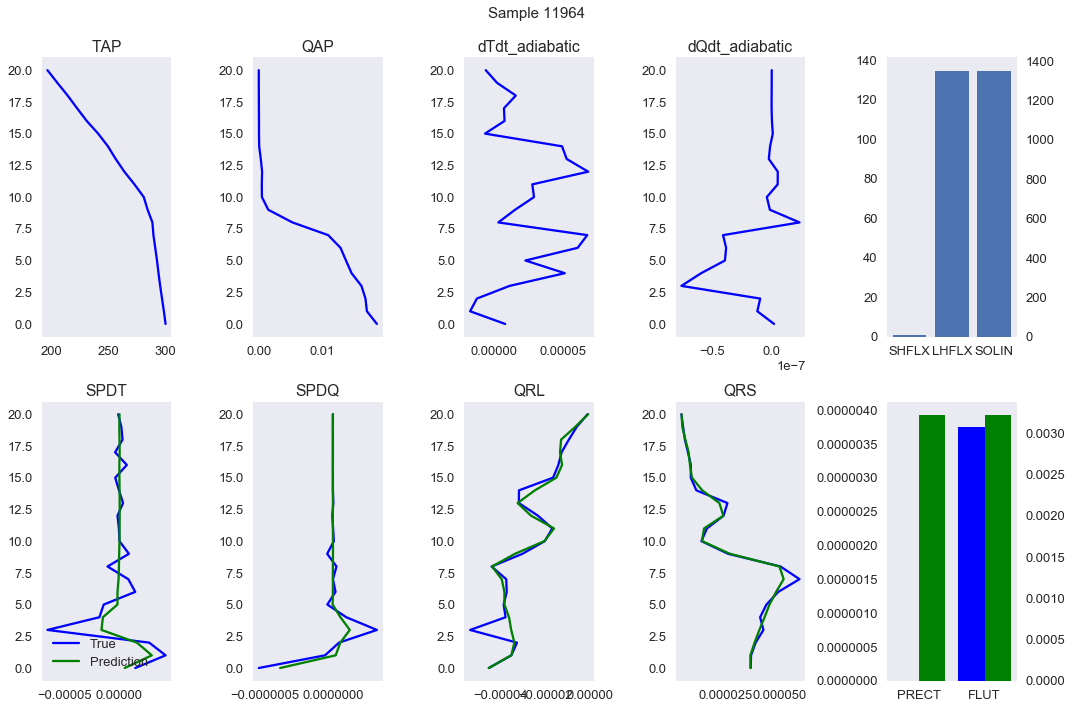

In [59]:
for i in list(np.random.randint(0, 3*n_geo, 3)):
    vis_features_targets_from_pred2(
        sample_features * norm.variables['feature_stds'] + norm.variables['feature_means'], 
        sample_targets, 
        sample_preds,
        sample_idx=i, 
        feature_names=feature_names, 
        target_names=target_names,
        unscale_targets=True
    )

I think these plots are quite nice because they really show what the network should do and what it does do. But of course this is no statistical analysis. Maybe this could be linked somehow to slide 6? If you would like these plots I would make them nicer and label them properly.

### Lat-lev slices of SPDT/SPDQ and QRL/QRS

In [ ]:
# Define conversion dict
L_V = 2.5e6   # Latent heat of vaporization is actually 2.26e6
C_P = 1e3 # Specific heat capacity of air at constant pressure
conversion_dict = {
    'SPDT': C_P,
    'SPDQ': L_V,
    'QRL': C_P,
    'QRS': C_P,
    'PRECT': 1e3*24*3600 * 1e-3,
    'FLUT': 1. * 1e-5,
}

In [270]:
sns.set_style("white")
from matplotlib.animation import FuncAnimation 
plt.rcParams['axes.facecolor']='black'
plt.rcParams['savefig.facecolor']='black'
plt.rcParams['text.color'] = 'white'
def plot_yz(targets, preds, itime, ilon, var='SP', anim=False, model=None, n_steps=20):
    # Reshape
    targets = targets.reshape((-1, n_lat, n_lon, targets.shape[-1]))
    preds = preds.reshape((-1, n_lat, n_lon, preds.shape[-1]))
    
    # Get indices
    tmp_idxs = np.arange(4*21)
    if var == 'SP':
        idxs = [tmp_idxs[:21], tmp_idxs[21:42]]
        names = ['SPDT', 'SPDQ']
        ranges = [[-5e-4, 5e-4], [-5e-7, 5e-7]]
        unit = ['K/s', 'kg/kg/s']
    elif var == 'QR':
        idxs = [tmp_idxs[42:63], tmp_idxs[63:84]]
        names = ['QRL', 'QRS']
        ranges = [[-2e-4, 2e-4], [-1.2e-4, 1.2e-4]]
        unit = ['K/s', 'K/s']
    
    # Unscale variables
    u = [conversion_dict[n] for n in names]
    
    # Plot
    fig, axes = plt.subplots(3, 2, figsize=(12.5,8.5), sharex=True, sharey=True,
                            facecolor='black')
    range_spdt = np.max(np.abs(targets[itime, :, ilon, idxs[0]] / u[0]))
    range_spdq = np.max(np.abs(targets[itime, :, ilon, idxs[1]] / u[1]))
    # Target SPDT
    I00 = axes[0, 0].imshow(targets[itime, :, ilon, idxs[0]] / u[0],
                       vmin=ranges[0][0], vmax=ranges[0][1], cmap='bwr')
    axes[0, 0].set_title('SPCAM ' + names[0])
    #fig.colorbar(I, ax=axes[0, 0], shrink=0.4)
    # Pred SPDT
    I10 = axes[1, 0].imshow(preds[itime, :, ilon, idxs[0]] / u[0],
                       vmin=ranges[0][0], vmax=ranges[0][1], cmap='bwr')
    axes[1, 0].set_title('CLOUDBRAIN ' + names[0])
    #fig.colorbar(I, ax=axes[1, 0], shrink=0.4)
    # Error 1
    e = preds[itime, :, ilon, idxs[0]] / u[0] - targets[itime, :, ilon, idxs[0]] / u[0]
    I20 = axes[2, 0].imshow(e,
                       vmin=ranges[0][0], vmax=ranges[0][1], cmap='bwr')
    axes[2, 0].set_title('Difference ' + names[0])
    cbar_ax_left = fig.add_axes([0.14, 0.1, 0.25, 0.02])
    cb_left = fig.colorbar(I20, cax=cbar_ax_left, orientation='horizontal', 
                            ticks=[ranges[0][0], 0, ranges[0][1]], format='%.0e')
    cb_left.set_label(unit[0], color='white')
    # Target SPDQ
    I01 = axes[0, 1].imshow(targets[itime, :, ilon, idxs[1]] / u[1],
                       vmin=ranges[1][0], vmax=ranges[1][1], cmap='bwr')
    axes[0, 1].set_title('SPCAM ' + names[1], color='white')
    #fig.colorbar(I, ax=axes[0, 1], shrink=0.4)
    # Pred SPDQ
    I11 = axes[1, 1].imshow(preds[itime, :, ilon, idxs[1]] / u[1],
                       vmin=ranges[1][0], vmax=ranges[1][1], cmap='bwr')
    axes[1, 1].set_title('CLOUDBRAIN ' + names[1])
    #fig.colorbar(I, ax=axes[1, 1], shrink=0.4)
    # Error 2
    e = preds[itime, :, ilon, idxs[1]] / u[1] - targets[itime, :, ilon, idxs[1]] / u[1]
    I21 = axes[2, 1].imshow(e,
                       vmin=ranges[1][0], vmax=ranges[1][1], cmap='bwr')
    axes[2, 1].set_title('Difference ' + names[1])
    fig.suptitle('', fontsize=17)
    fig.subplots_adjust(bottom=0.15, wspace=0.1, hspace=0.25, left=0.05, right=0.95, top=0.9)
    cbar_ax_right = fig.add_axes([0.62, 0.1, 0.25, 0.02])
    cb_right = fig.colorbar(I21, cax=cbar_ax_right, orientation='horizontal', 
                            ticks=[ranges[1][0], 0, ranges[1][1]], format='%.0e')
    cb_right.set_label(unit[1], color='white')
    cb_right.ax.tick_params(axis='x', colors='white')
    cb_left.ax.tick_params(axis='x', colors='white')
    
    for ax in list(np.ravel(axes)):
        ax.set_xticks([])
        ax.set_yticks([])
    sns.despine(left=True, bottom=True)
    #plt.tight_layout()
    if anim:
        gen_obj = DataGenerator(
            data_dir,
            'valid_year1' + '_features.nc',
            'valid_year1' + '_targets.nc',
            shuffle=False,
            batch_size=n_geo,
            verbose=False,
        )
        gen = gen_obj.return_generator()
        def update(i):
            tmp_features, tmp_targets = next(gen)
            # Get predictions
            tmp_preds = model.predict_on_batch(tmp_features)
            targets = tmp_targets.reshape((-1, n_lat, n_lon, tmp_targets.shape[-1]))
            preds = tmp_preds.reshape((-1, n_lat, n_lon, tmp_preds.shape[-1]))
            I00.set_data(targets[itime, :, ilon, idxs[0]] / u[0])
            I10.set_data(preds[itime, :, ilon, idxs[0]] / u[0])
            I20.set_data(preds[itime, :, ilon, idxs[0]] / u[0] - 
                         targets[itime, :, ilon, idxs[0]] / u[0])
            I01.set_data(targets[itime, :, ilon, idxs[1]] / u[1])
            I11.set_data(preds[itime, :, ilon, idxs[1]] / u[1])
            I21.set_data(preds[itime, :, ilon, idxs[1]] / u[1] - 
                         targets[itime, :, ilon, idxs[1]] / u[1])
            fig.suptitle('Day: %.2f' % (i / 48.), fontsize=17)
            return I00, I10, I20, I01, I11, I21
        return FuncAnimation(fig, update, frames=np.arange(n_steps), interval=150, blit=True)
    else:
        plt.show()

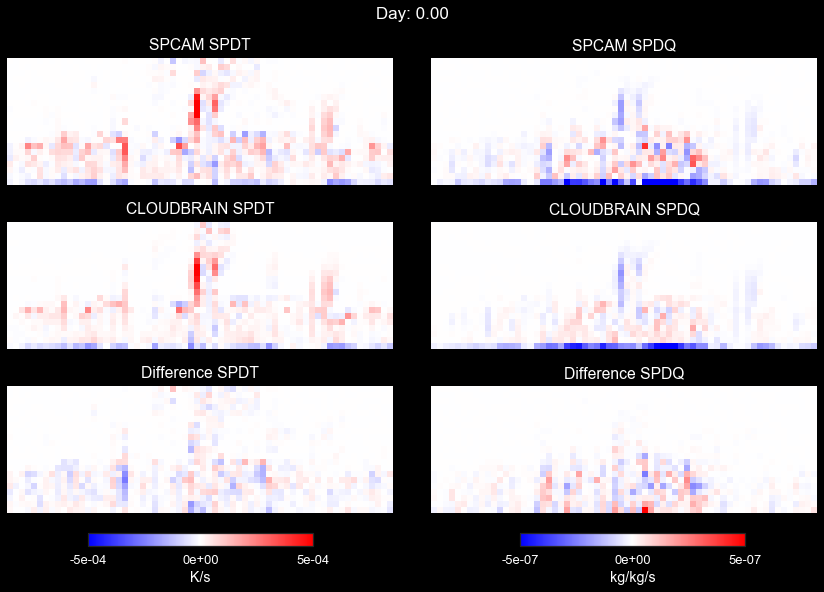

In [271]:
model = keras.models.load_model('./models/002_1year_shuffle.h5')
anim = plot_yz(sample_targets, sample_preds, 0, 10, 'SP', anim=True, model=model, n_steps=96)

In [272]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/s/S.Rasp/tmp/animation_for_Mike_1.mp4', dpi=80)